# Kaggle Galaxy Zoo Competition

In [1]:
%matplotlib inline

path = "data/galaxy/sample/"
#path = "data/galaxy/"

train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
results_path = path + 'results/'
model_path = path + 'model/'

In [2]:
from utils import *

Using Theano backend.


In [3]:
batch_size = 32
num_epoch = 1

In [4]:
import pandas as pd
df = pd.read_csv(path+ "train.csv")
df_val = pd.read_csv(path+ "valid.csv")

In [5]:
# custom iterator for regression
import Iterator; reload(Iterator)
from Iterator import DirectoryIterator

imgen = image.ImageDataGenerator()
# imgen = image.ImageDataGenerator(samplewise_center=0,
#                                rotation_range=360,
#                                width_shift_range=0.05,
#                                height_shift_range=0.05,
#                                zoom_range=[0.9,1.2],
#                                horizontal_flip=True,
#                                channel_shift_range=0.1,
#                                dim_ordering='tf')

batches = DirectoryIterator(train_path, imgen, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4,
                            target_size=(128,128))

val_imgen = image.ImageDataGenerator()
val_batches = DirectoryIterator(valid_path, val_imgen, 
                                class_mode=None, 
                                dataframe=df_val,
                                batch_size=4,
                                target_size=(128,128))

Found 1500 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


In [6]:
imgs, target = next(batches)
imgs[0].shape

(3, 128, 128)

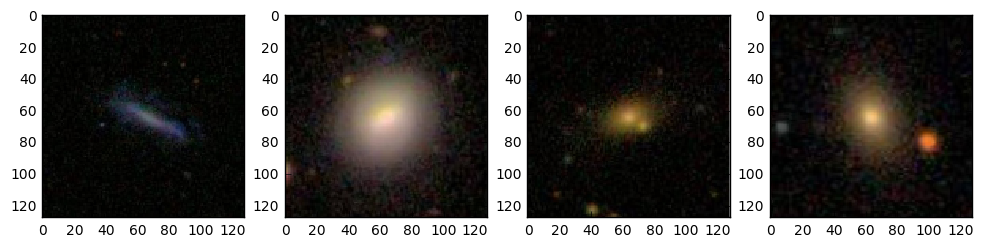

In [7]:
plots(imgs)

### First Model
2 layer CNN

In [35]:
def conv1():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,128,128)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(37)
        ])
    
    model.compile(Adam(lr=0.0001), loss='mse')
    return model

In [36]:
model = conv1()

In [37]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNorma (None, 3, 128, 128)   12          batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 32, 126, 126)  896         batchnormalization_5[0][0]       
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 32, 126, 126)  128         convolution2d_3[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 42, 42)    0           batchnormalization_6[0][0]       
___________________________________________________________________________________________

In [39]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
1500/1500 [==============================] - 166s - loss: 0.0276 - val_loss: 0.5723
Epoch 2/5
1500/1500 [==============================] - 169s - loss: 0.0269 - val_loss: 0.4793
Epoch 3/5
1500/1500 [==============================] - 167s - loss: 0.0249 - val_loss: 0.3952
Epoch 4/5
1500/1500 [==============================] - 173s - loss: 0.0227 - val_loss: 0.4315
Epoch 5/5
1500/1500 [==============================] - 177s - loss: 0.0212 - val_loss: 0.4899


In [40]:
model.save_weights(model_path+'conv1.h5')

IOError: Unable to create file (Unable to open file: name = 'data/galaxy/sample/model/conv1.h5', errno = 2, error message = 'no such file or directory', flags = 13, o_flags = 242)

In [41]:
train_files = batches.filenames
train_out = model.predict_generator(batches, batches.nb_sample)

In [42]:
features = list(df.columns.values)
train_ids = [os.path.splitext(f) for f in train_files]
submission = pd.DataFrame(train_out, columns=features[2:])
submission.insert(0, 'GalaxyID', [int(a[0][7:]) for a in train_ids])
submission.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,924379,0.367520,0.561333,0.115973,0.150327,0.483033,0.238037,0.373579,0.220091,0.359443,...,-0.039242,0.080177,0.124867,-0.082719,0.020087,0.091014,-0.091263,0.137756,0.152649,-0.008117
1,147167,0.540400,0.413963,0.091599,-0.045269,0.519202,-0.013316,0.676015,-0.076467,0.588773,...,-0.137199,0.089525,-0.084473,-0.306001,-0.001732,-0.337648,-0.018401,0.054607,0.017542,-0.113913
2,248672,0.419048,0.493675,0.097793,-0.086601,0.413475,-0.033470,0.619101,0.277853,0.252884,...,-0.102920,-0.040183,0.063529,0.142905,-0.007786,0.157779,-0.137922,0.061960,0.058448,0.043160
3,326130,0.566251,0.408165,0.155597,0.244909,0.252496,0.139492,0.080757,-0.192909,0.227937,...,0.045965,-0.186001,-0.033867,0.085872,0.043383,-0.124458,-0.168669,-0.028036,-0.037061,-0.039913
4,742246,0.377746,0.603907,0.037420,-0.077519,0.731572,0.149130,0.640511,0.425540,0.369370,...,-0.066592,0.189428,0.070469,-0.083087,0.124276,-0.061790,-0.106651,0.068581,0.021298,0.040755


In [43]:
df.loc[df['GalaxyID'] == 924379]

,Unnamed: 0,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
912,56443,924379,0.969858,0.0,0.030142,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
val_files = val_batches.filenames
val_out = model.predict_generator(val_batches, val_batches.nb_sample)

In [27]:
features = list(df_val.columns.values)
val_ids = [os.path.splitext(f) for f in val_files]
submission = pd.DataFrame(val_out, columns=features[2:])
submission.insert(0, 'GalaxyID', [int(a[0][7:]) for a in val_ids])
submission.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,546684,-0.303058,1.016096,0.192375,-0.288990,0.910400,-0.270041,0.593910,0.698536,-0.227012,...,0.946784,0.971490,-0.066917,-0.581107,0.590464,0.269726,-0.617541,0.053022,-0.512617,0.541198
1,721408,-0.414673,1.405507,-0.061038,-0.548751,1.189219,-0.429791,0.731134,0.776573,-0.286131,...,0.963670,0.780082,-0.119708,-0.719127,0.678132,0.558736,-0.415017,0.356685,-0.881183,0.886710
2,985641,0.773234,0.552989,-0.095795,-0.128255,0.565860,-0.081701,0.459830,0.317089,0.072096,...,0.134163,-0.067865,-0.149972,-0.142088,0.093223,-0.044411,-0.257437,0.229226,-0.210334,0.091198
3,625287,-0.099725,1.311387,-0.079144,-0.486842,1.064716,-0.352063,0.895597,0.696261,-0.317608,...,0.819696,0.679131,-0.088235,-0.783947,0.520898,0.255738,-0.549587,0.523057,-0.509953,0.567748
4,295804,0.328599,1.156847,0.167752,-0.332028,1.033803,-0.252413,0.680216,0.571441,0.101412,...,0.506432,0.249702,-0.409789,-0.699563,0.607565,0.590292,-0.532929,0.125270,-0.591788,0.447076


In [28]:
df_val.loc[df_val['GalaxyID'] == 546684]

,Unnamed: 0,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
229,30459,546684,0.567677,0.418564,0.013759,0.0,0.418564,0.1797,0.238864,0.327629,...,0.0,0.0,0.0,0.327629,0.0,0.327629,0.0,0.0,0.0,0.0


In [12]:
test_batches = get_batches(test_path, batch_size=64, target_size=(128,128))

Found 50 images belonging to 1 classes.


In [13]:
test_files = test_batches.filenames
test_out = model.predict_generator(test_batches, test_batches.nb_sample)
save_array(results_path+'test_out.dat', test_out)

In [14]:
features = list(df.columns.values)
test_ids = [os.path.splitext(f) for f in test_files]
submission = pd.DataFrame(test_out, columns=features[2:])
submission.insert(0, 'GalaxyID', [int(a[0][7:]) for a in test_ids])
submission.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,648115,-0.245553,1.203182,0.054164,-0.341361,0.925859,-0.354565,0.728692,0.770186,-0.445721,...,0.987202,0.968185,-0.327392,-0.648208,0.963967,0.255738,-0.613678,0.223765,-0.602802,0.630970
1,592365,0.064200,1.136645,0.052554,-0.372949,0.963706,-0.269145,0.724294,0.311045,0.204930,...,0.644243,0.433342,-0.202798,-0.583269,0.556684,0.284477,-0.268265,0.081323,-0.342887,0.345586
2,774656,-0.611048,1.518129,-0.235328,-0.751215,1.616381,-0.810157,0.850286,0.820305,-0.634729,...,1.488565,0.831436,-0.208339,-1.236019,1.090243,0.615463,-0.526344,0.480478,-0.680136,0.677535
3,844798,-1.078425,1.917772,-0.238720,-1.299413,1.889346,-0.823791,1.016641,1.304779,-0.620595,...,1.258587,0.790865,-0.398396,-1.189538,1.090074,0.594323,-0.580836,0.198425,-0.490177,0.811281
4,925830,-1.487606,1.776191,0.208448,-0.487335,0.952913,-1.286454,1.074650,0.653918,-0.865903,...,2.168741,1.077392,0.042768,-1.522296,1.009825,0.540846,-0.634637,0.308209,-0.534980,0.942997


In [15]:
subm_name = results_path+'subm.csv'
submission.to_csv(subm_name, index=False)
FileLink(subm_name)

/home/ubuntu/fastai/nbs/data/galaxy/sample/results/subm.csv

## To Do:

1. Data Augmentation to reduce overfitting
2. Custom output layer for output question constraints
3. Dropout on dense layers (need all the data)
4. Larger network, different arch

### Data Augmentation

TODO: Crop images

In [ ]:
imgen_aug = image.ImageDataGenerator(horizontal_flip=True)
batches = DirectoryIterator(train_path, imgen_aug, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)
model = conv1()
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 1500 images belonging to 1 classes.
Epoch 1/5
1500/1500 [==============================] - 254s - loss: 0.1065 - val_loss: 212.2430
Epoch 2/5
1500/1500 [==============================] - 283s - loss: 0.0562 - val_loss: 0.5155
Epoch 3/5
1500/1500 [==============================] - 408s - loss: 0.0390 - val_loss: 0.2847
Epoch 4/5
1500/1500 [==============================] - 627s - loss: 0.0292 - val_loss: 157.9813
Epoch 5/5
1500/1500 [==============================] - 666s - loss: 0.0269 - val_loss: 18.7991


In [ ]:
imgen_aug = image.ImageDataGenerator(rotation_range=360)
batches = DirectoryIterator(train_path, imgen_aug, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)
model = conv1()
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 1500 images belonging to 1 classes.
Epoch 1/5
 244/1500 [===>..........................] - ETA: 398s - loss: 0.2137

In [ ]:
imgen_aug = image.ImageDataGenerator(width_shift_range=0.05)
batches = DirectoryIterator(train_path, imgen_aug, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)
model = conv1()
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [9]:
imgen_aug = image.ImageDataGenerator(channel_shift_range=20)
batches = DirectoryIterator(train_path, imgen_aug, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)
model = conv1()
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 1500 images belonging to 1 classes.
Epoch 1/5
1500/1500 [==============================] - 245s - loss: 0.1264 - val_loss: 0.0436
Epoch 2/5
1500/1500 [==============================] - 243s - loss: 0.0477 - val_loss: 0.1824
Epoch 3/5
1500/1500 [==============================] - 243s - loss: 0.0385 - val_loss: 0.0302
Epoch 4/5
1500/1500 [==============================] - 243s - loss: 0.0329 - val_loss: 0.0290
Epoch 5/5
1500/1500 [==============================] - 242s - loss: 0.0323 - val_loss: 0.0287


In [10]:
imgen_aug = image.ImageDataGenerator(horizontal_flip=True,
                                    rotation_range=180,
                                    width_shift_range=0.05,
                                    channel_shift_range=20)
batches = DirectoryIterator(train_path, imgen_aug, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)
model = conv1()
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 1500 images belonging to 1 classes.
Epoch 1/5
1500/1500 [==============================] - 246s - loss: 0.1070 - val_loss: 0.0347
Epoch 2/5
1500/1500 [==============================] - 246s - loss: 0.0383 - val_loss: 0.0325
Epoch 3/5
1500/1500 [==============================] - 245s - loss: 0.0380 - val_loss: 0.0328
Epoch 4/5
1500/1500 [==============================] - 246s - loss: 0.0346 - val_loss: 0.0323
Epoch 5/5
1500/1500 [==============================] - 246s - loss: 0.0341 - val_loss: 0.0272


In [12]:
model.optimizer.lr = 0.0001
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, 
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
1500/1500 [==============================] - 247s - loss: 0.0325 - val_loss: 0.0272
Epoch 2/5
1500/1500 [==============================] - 246s - loss: 0.0331 - val_loss: 0.0285
Epoch 3/5
1500/1500 [==============================] - 247s - loss: 0.0343 - val_loss: 0.0309
Epoch 4/5
1500/1500 [==============================] - 246s - loss: 0.0337 - val_loss: 0.0262
Epoch 5/5
1500/1500 [==============================] - 245s - loss: 0.0347 - val_loss: 0.0305


### Output Layer

TODO: test this using outputs from conv1

In [36]:
def output_constraint(x):
    q1 = K.softmax(x[:, 0:3])
    q2 = K.softmax(x[:, 3:5])
    q3 = K.softmax(x[:, 5:7])
    q4 = K.softmax(x[:, 7:9])
    q5 = K.softmax(x[:, 9:13])
    q6 = K.softmax(x[:, 13:15])
    q7 = K.softmax(x[:, 15:18])
    q8 = K.softmax(x[:, 18:25])
    q9 = K.softmax(x[:, 25:28])
    q10 = K.softmax(x[:, 28:31])
    q11 = K.softmax(x[:, 31:37])
    
    return K.concatenate([q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11])

In [37]:
def conv1_outconst():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(37),
            Lambda(output_constraint, output_shape=None)
        ])
    
    model.compile(Adam(lr=0.001), loss='mse')
    return model

In [38]:
model = conv1_outconst()
model.summary()

/home/ubuntu/anaconda2/envs/fastai/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 37)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_37 (BatchNorm (None, 3, 256, 256)   12          batchnormalization_input_7[0][0] 
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 32, 254, 254)  896         batchnormalization_37[0][0]      
____________________________________________________________________________________________________
batchnormalization_38 (BatchNorm (None, 32, 254, 254)  128         convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 32, 84, 84)    0           batchnormalization_38[0][0]      
___________________________________________________________________________________________

In [39]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, 
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
1500/1500 [==============================] - 250s - loss: 0.0724 - val_loss: 0.0614
Epoch 2/5
1500/1500 [==============================] - 248s - loss: 0.0632 - val_loss: 0.0626
Epoch 3/5
1500/1500 [==============================] - 250s - loss: 0.0638 - val_loss: 0.0625
Epoch 4/5
1500/1500 [==============================] - 249s - loss: 0.0628 - val_loss: 0.0602
Epoch 5/5
1500/1500 [==============================] - 248s - loss: 0.0624 - val_loss: 0.0602


### Regularization